# Gibbs sampler for Linear Regression with independent Normal-Gamma Prior

See Koop p. 60

## Generate some data

In [23]:
X <- matrix(rnorm(1500, 0, 50), ncol = 3)
X <- cbind(1, X)

N <- nrow(X)
M <- ncol(X)
true_beta <- as.matrix(c(52, 3, 7, -24), ncol = 1)
y <- X %*% true_beta + rnorm(N, 0, 50)

## Define Hyperparameters for independent Normal-Gamma prior:

+ Error precision $h$:
    + $\nu_0$: prior degrees of freedom
    + $s_0^{-2}$: prior mean (defined below as its inverse $s_0^2$ since that is what occurs in the calculation)
+ Coefficients $\beta$:
    + $\beta_0$: prior mean
    + $V_0$: prior covariance matrix
    
## Other Quantities

- N: Number of observations
- M: Number of coefficients

Hyperparameters for error precision $h$:

In [24]:
nu0 <- 50
s02 <- 1/10e-5

Hyperparameters for coefficients $\beta$

In [25]:
beta0 <- matrix(c(50, 0, 10, -20), ncol = 1)
V0 <- diag(c(20, 5, 20, 10))
V0inv <- diag(diag(1/V0))

## Calculate OLS quantities

- $\beta_{OLS}$: Coefficients
- $\varepsilon_{OLS}$: Errors
- $df_{OLS}$: Degrees of Freedom
- $s^2_{OLS}$: Error variance

In [26]:
XX <- crossprod(X)
XXinv <- solve(XX)
Xy <- crossprod(X, y)

betaOLS <- XXinv %*% Xy

epsOLS <- y - X %*% betaOLS
dfOLS <- N - M
s2OLS <- crossprod(epsOLS)/dfOLS

## Posterior Quantities

- Error precision $h$:
    + $\nu_1$: Posterior degrees of freedom
        
        $$
        \nu_1 = \nu_0 + N
        $$
        
    + $s_1^{-2}$: Posterior mean
    
        $$
        s_1^{-2} = {\varepsilon(\beta)'\varepsilon(\beta) + \nu_0 s_0^2 \over \nu_1}
        $$
        
      where $\varepsilon(\beta) = y - X'\beta^{(i)}$ indicates the dependence of $\varepsilon$ on the current draw of $\beta = \beta^{(i)}$.
      
- Coefficients $\beta$:
    + $\beta_1$: Posterior mean
    
        $$
        \beta_1 = V_1(V_0^{-1} \beta_0 + h X'y)
        $$
        
    + $V_1$: Posterior covariance matrix
    
        $$
        V_1 = (V_0^{-1} + h X'X)^{-1}
        $$


In [27]:
nu1 <- nu0 + N

## Gibbs setup

### Parameterization of Gamma distribution 

* Koop:

    $$
    X \sim G(\mu, \nu) \\
    f_G(x\ |\ \mu, \nu) = c_G^{-1} x^{{\nu-2 \over 2}} exp\left(-{x \nu \over 2 \mu}\right) \quad if\ 0 < x < \infty
    $$

where $c_G = \left({2\mu \over \nu}\right)^{{\nu \over 2}} \Gamma\left({\nu \over 2}\right) \Rightarrow c^{-1}_G = {\left({\nu \over 2\mu }\right)^{{\nu \over 2}} \over \Gamma\left({\nu \over 2}\right)}$

* R (shape, rate):

    $$
    f(x\ |\ \alpha, \beta) = {\beta^\alpha \over \Gamma(\alpha)} x^{\alpha - 1} exp(-\beta x)
    $$

* R (shape, scale):

    $$
    f(x\ |\ \alpha, \theta) = {1 \over \theta^\alpha \Gamma(\alpha)} x^{\alpha-1} e^{-(x/\theta)}
    $$

* Reparameterize:
    - Shape = $\alpha$
    - Rate = $\beta$
    - Scale = $\theta$
    + DF = $\nu$
    + Mean = $\mu$

    $$
    \alpha = {\nu \over 2} \equiv 0.5 * \nu_1 \\
    \beta = {\nu \over 2 \mu} \equiv 0.5 * \nu_1 * s_1^2 \\
    \theta = {1 \over \beta} \equiv {1 \over 0.5 * \nu_1 * s_1^2}
    $$

Where $\nu_1$ are the posterior degrees of freedom of the error precision and $s_1^2$ is the inverse of the posterior mean of the error precision. 

In [28]:
Shape <- function(nu){
    return(0.5 * nu)
}

Rate <- function(nu, s12){
    return(Shape(nu) * s12)
}

Scale <- function(nu, s12){
    return(1/Rate(nu, s12))
}

### Draws
+ d_burn: number of burn-in draws
+ d_save: number of saved draws

In [29]:
d_burn <- 500
d_save <- 10000
d_tot <- d_burn + d_save

### Storage matrices for the parameters

In [30]:
beta_store <- matrix(NA, nrow = d_save, ncol = M)
h_store <- matrix(NA, nrow = d_save, ncol = 1)
y_pred_store <- matrix(NA, nrow = d_save, ncol = 1)

### Prediction
$$
x_1 = 50 \\
x_2 = 10 \\
x_3 = 20 \\
y_{pred} = ?
$$

In [31]:
x_pred <- c(1, 50, 10, -200)

### Initial draw of $h$

In [32]:
h_draw <- as.numeric(1/s2OLS)

## Gibbs Loop

1. Draw $\beta$ conditional on $h$
    - $\beta\ |\ y,\ h \sim N(\beta_1(h), V_1(h))$
    
2. Draw $h$ conditional on $\beta$
    - $h \ |\ y,\ \beta \sim G(\mu = s_1^{-2}(\beta)),\ df = \nu_1) \equiv G(shape = Shape(\nu_1), rate = Rate(\nu_1,\ s_1^2(\beta))$
    
3. Discard if current iteration $\leq$ burn-in or save to respective storage matrices if current iteration > burn-in

4. Save prediction given current draws of parameters

In [33]:
start <- Sys.time()
for(iter in 1:d_tot){
    # 1. Draw beta conditional on h
    V1inv <- V0inv + h_draw * XX
    V1 <- solve(V1inv)
    beta1 <- V1 %*% (V0inv %*% beta0 + h_draw * Xy)
    beta_draw <- beta1 + t(chol(V1)) %*% rnorm(M)
    
    # 2. Draw h conditional on beta
    eps <- y - X %*% beta_draw
    s12 <- (1/nu1) * (crossprod(eps) + nu0 * s02) 
    h_draw <- rgamma(1, shape = Shape(nu1), rate = Rate(nu1, s12))
    
    # 3. Discard or save 
    if (iter > d_burn){
        row <- iter-d_burn
        beta_store[row, ] <- beta_draw
        h_store[row, 1] <- h_draw 
        y_pred_store[row, 1] <- x_pred %*% beta_draw + rnorm(1, 0, 1/h_draw)
    }
}
end <- Sys.time()
end-start

Time difference of 0.5859358 secs

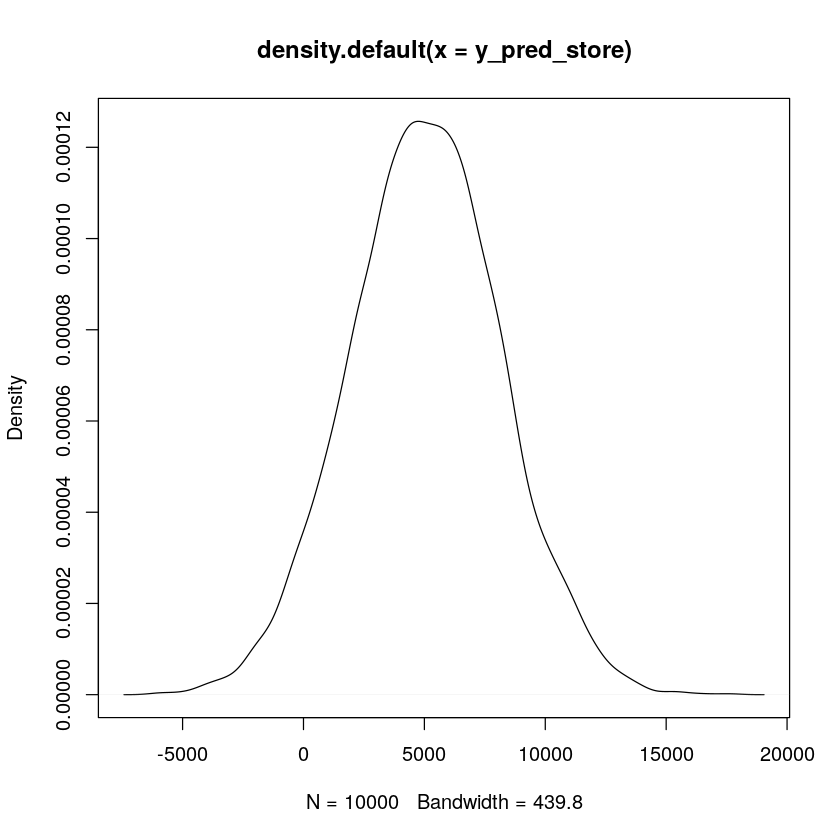

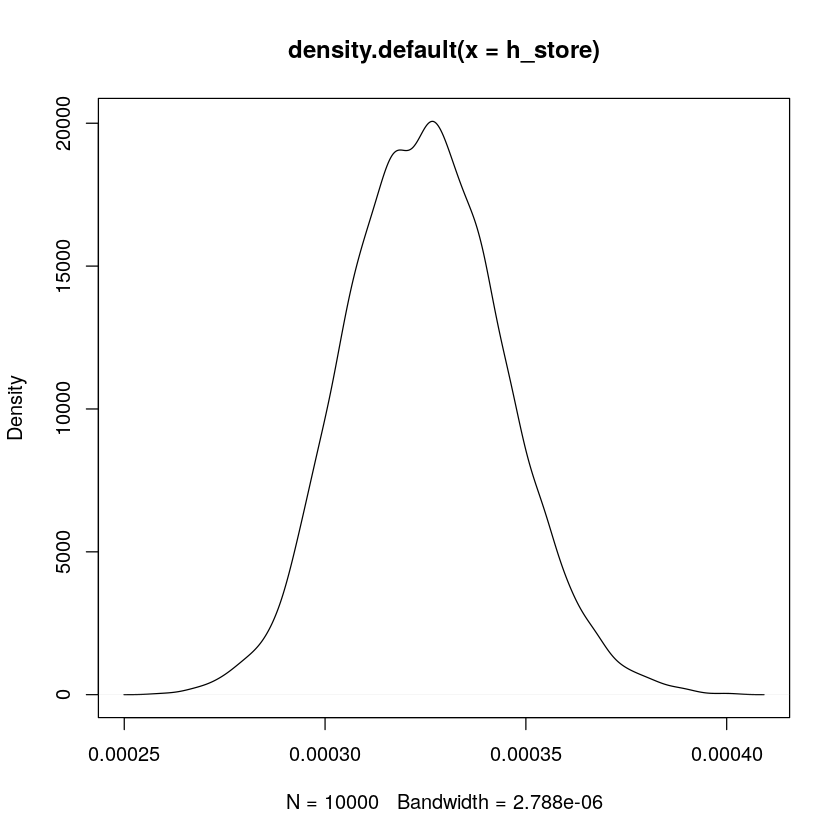

In [34]:
plot(density(y_pred_store))
plot(density(h_store))

In [35]:
library(Rcpp)


In [36]:
sourceCpp("gibbsOnly.cpp")

Time difference of 0.3766892 secs

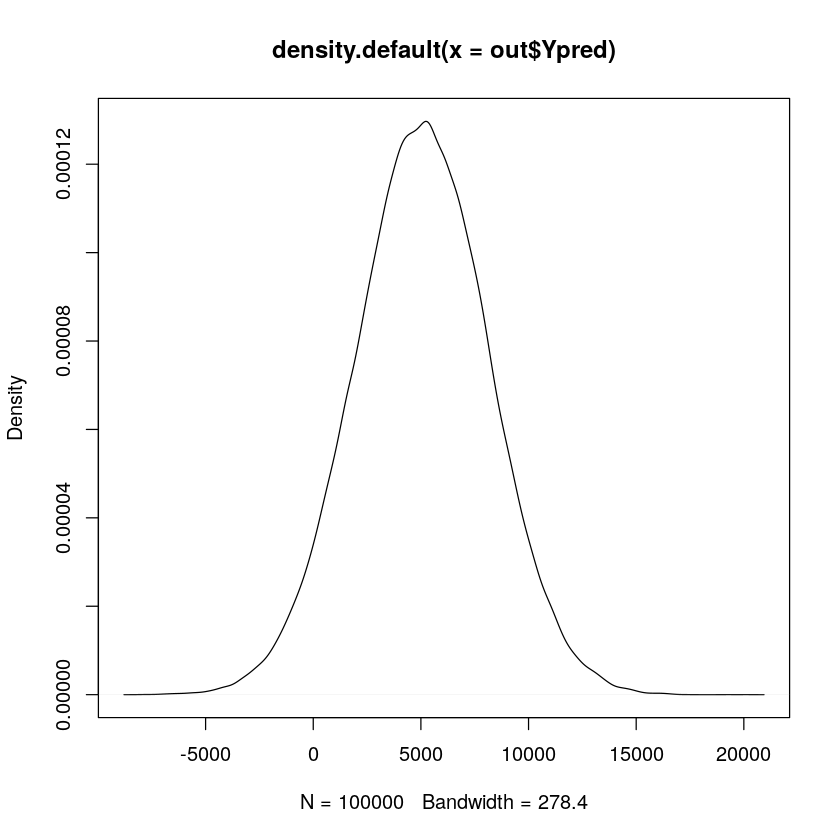

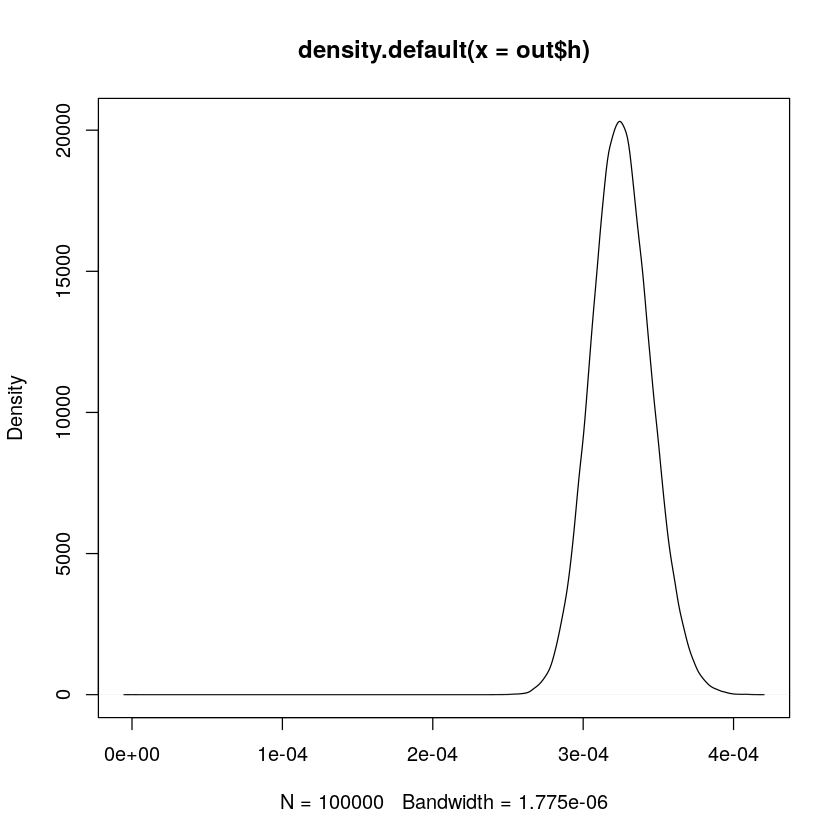

In [39]:
start <- Sys.time()
out <- iNG(X, y, V0inv, beta0, nu0, s02, h_draw, 100000, 1000, x_pred)
end <- Sys.time()
end-start
plot(density(out$Ypred))
plot(density(out$h))

In [12]:
library(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

standat <- list(N = length(y), M = ncol(X), 
                X = X, y = as.vector(y), 
                x_pred = x_pred,
                beta_0 = as.vector(beta0), V_0 = diag(V0), nu_0 = nu0, s_02 = s02)
model_stan <- stan("iNG.stan", data = standat, chains = 4, iter = 10000, seed = 1234, refresh = 2000)

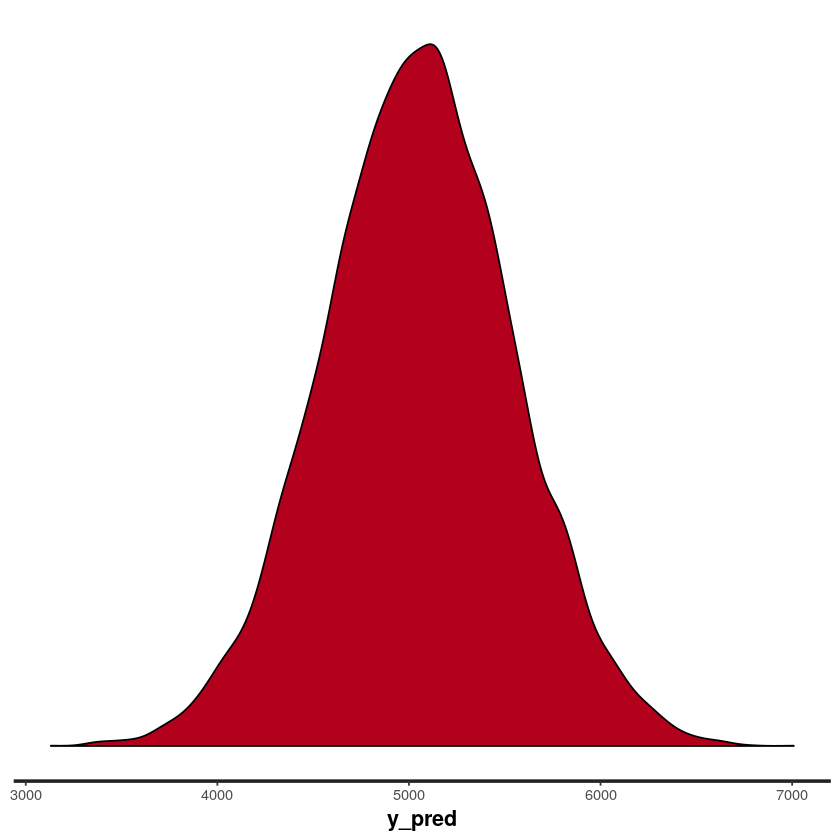

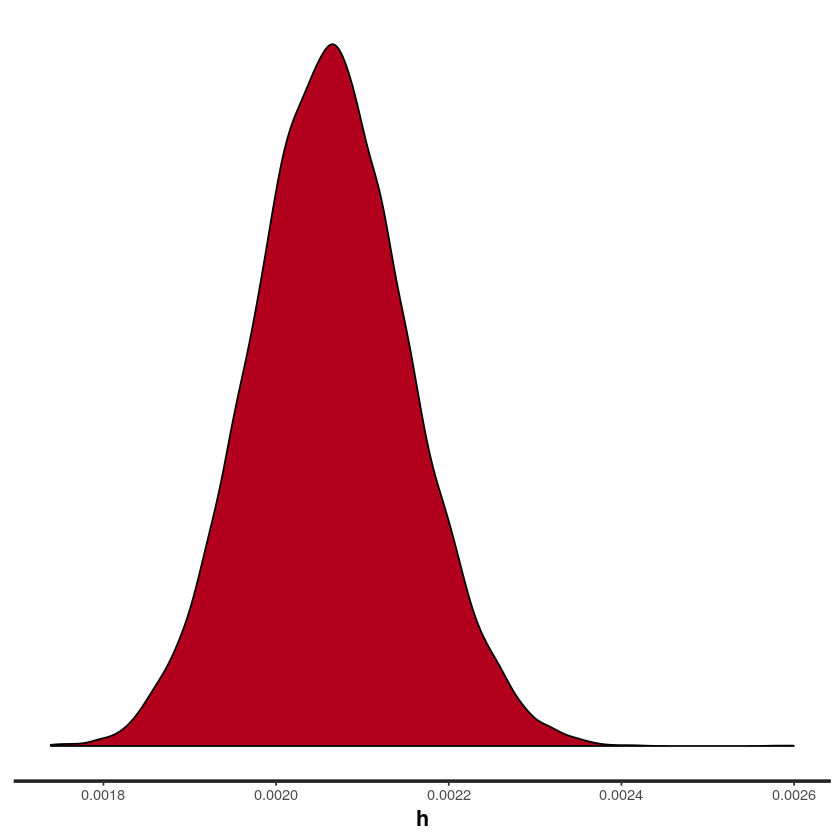

In [40]:
plot(model_stan, plotfun = 'dens', pars = 'y_pred')
plot(model_stan, plotfun = 'dens', pars = 'h')